# OSU Micro Benchmarks (IMB)

Results of selected latency and bandwidth tests from the [OMB suite](http://mvapich.cse.ohio-state.edu/benchmarks/).

All these tests use two nodes:

- osu_bw: Single process per node
- osu_latency: Single process per node
- osu_bibw (Bidirectional Bandwidth Test): Single process per node
- osu_mbw_mr (Multiple Bandwidth / Message Rate Test): Multiple processes per node, communicating in pairs split across nodes


In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size

The plots below show results vs message size for tests using a single process per node. Results are for the most-recent test on each system/partition/environment combination.

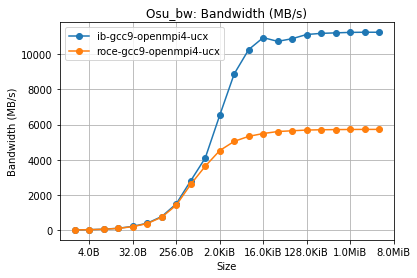

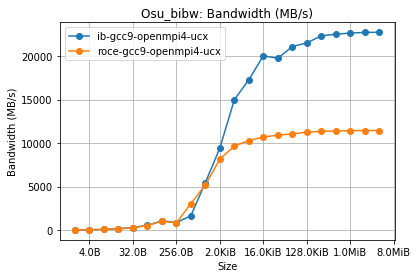

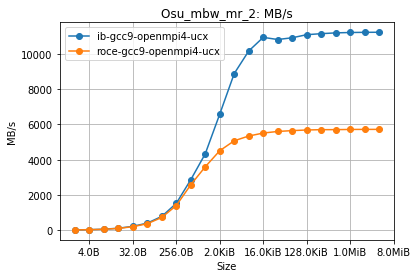

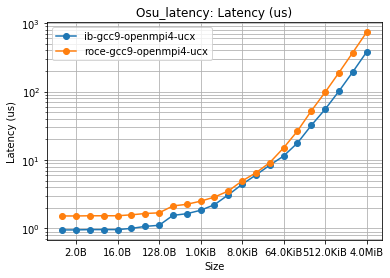

In [10]:
for test in ['Osu_bw', 'Osu_bibw', 'Osu_mbw_mr_2', 'Osu_latency']:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    common, meta_diffs = modules.utils.diff_dicts([modules.utils.parse_path_metadata(p) for p in paths], ignore=['path'])
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.omb.read_omb_out(path)
        label = '-'.join(meta_diffs[ix].values())
        plt.plot(data.columns[0], data.columns[1], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    if 'latency' in test:
        ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel(data.columns[0])
    ax.set_ylabel(data.columns[1])
    ax.set_title('%s: %s' % (test, data.columns[1]))
    ax.legend()

# Max Bandwidth/Message Rate vs Number of Processes per Node

The plots below show the **maximum** bandwidth and message rate for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

In [11]:
# TODO: needs to be loaded from system config somewhere
Gb_to_MB = 125.0
ALASKA_BANDWIDTH = {'ib': 100 * 125.0, 'roce': 25 * Gb_to_MB}

for test in ['Osu_mbw_mr_*']:
    
    # load perf records:
    perf_records = modules.utils.load_perf_logs('../perflogs', test, '.log')
    
    # calculate number of processes (=tasks):
    perf_records['procs_per_node'] = [int(tn.rsplit('_')[-1]) for tn in perf_records['testname']]
    
    # plot/tabulate:
    for perf_var in ['max_bandwidth', 'max_message_rate']:
        
        perf_unit = perf_records[perf_records['perf_var'] == perf_var]['perf_unit'].iloc[0] # assumes unique
        table = modules.plots.tabulate_last_perf_vs(perf_records, 'procs_per_node', perf_var)
        ax = table.plot(grid=True, style='o-')
        
        if 'bandwidth' in perf_var:
            xlim = ax.get_xlim()
            for net, bw in ALASKA_BANDWIDTH.items():
                ax.plot(xlim, [bw, bw], '--', label=net)
        
        ax.set_xlabel('processes per node')
        ax.set_ylabel('%s (%s)' % (perf_var, perf_unit))
        plt.tight_layout()
        ax.set_title('%s: %s' % (test, perf_var))
        ax.legend()
        print('%s: %s (%s)' % (test, perf_var, perf_unit))
        display(HTML(table.to_html()))


TypeError: 'NoneType' object is not subscriptable